<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/example_attention_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of Attention mechanism

In [12]:
# basic
import math

# PyTorch
import torch
import torch.nn.functional as F

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# random tensors function from https://rockt.github.io/2018/04/30/einsum
def random_tensors(shape, num=1, requires_grad=False):
    tensors = [torch.randn(shape, requires_grad=requires_grad) for i in range(0,num)]
    return tensors[0] if num == 1 else tensors

In [276]:
Y = {
     "apple": 9,
     "banana": 5,
     "chair": 2,
     }
print(Y.keys())
print(Y.values())

query = "apple"
print(Y[query])

dict_keys(['apple', 'banana', 'chair'])
dict_values([9, 5, 2])
9


For example, say we assign a 60% meaning based match for apple, a 40% match for banana, and 0% match for chair. We compute our final output value as the weighted sum of the values with the percentages:

In [278]:
query = "fruit"
Y_attn = 0.6 * Y["apple"] + 0.4 * Y["banana"] + 0.0 * Y["chair"]
print(Y_attn)

7.3999999999999995


## Attention function

Query (Q): Represents the word you’re focusing on.

Key (K): Represents every other word in the sentence, helping the model decide which ones are important.

Value (V): Contains the actual information that the model will focus on.

In [327]:
# dimensions = batch size x sequence length x embedding dimension
#Y = random_tensors([3, 2, 4])

#Y = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

#Q = [[2., 0., 0.],[2., 0., 0.],[2., 0., 0.]]

K = [[1., 0., 0.],[0., 0., 1.],[0., 0., 1.]]
V = [[9., 5., 2.],[5., 5., 5.],[2., 2., 2.]]
Q = [[0., 0., 2.]]

#K = [[0., 1., 0.]]
#V = [[9., 5., 2.]]

Q = torch.tensor(Q)
K = torch.tensor(K)
V = torch.tensor(V)
print(Q)
print(K)

tensor([[0., 0., 2.]])
tensor([[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.]])


In [241]:
print(torch.transpose(K,0,1))

tensor([[1., 4., 7.],
        [2., 5., 8.],
        [3., 6., 9.]])


In [311]:
scores = torch.matmul(Q, torch.transpose(K,0,1)) / math.sqrt(Q.size(-1))
print(scores)
p_attn = F.softmax(scores, dim = -1)
print(p_attn)
print(torch.matmul(p_attn, V))

tensor([[4.6188, 0.0000, 0.0000]])
tensor([[0.9807, 0.0097, 0.0097]])
tensor([[8.8936, 4.9710, 2.0290]])


In [226]:
# attention function based on http://nlp.seas.harvard.edu/2018/04/03/attention.html#attention
def attention_transf(query, key, value):
    "Compute 'Scaled Dot Product Attention'"

    # scaling factor for scores
    d_k = query.size(-1)

    # matrix multiplication to get every dot product for query and transposed key
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    #scores = torch.matmul(query, torch.transpose(key,0,1)) / math.sqrt(d_k)

    # apply softmax of the scores on the last dimensions (= sequence length)
    p_attn = F.softmax(scores, dim = -1)

    # matrix multiplication of attention matrix and value matrix to get output based
    out = torch.matmul(p_attn, value)

    return out, p_attn

In [328]:
# run Y through attention function
#out, p_attn = attention_transf(Y, Y, Y)
out, p_attn = attention_transf(Q, K, V)

In [228]:
# print shapes
Q.shape, p_attn.shape, out.shape

(torch.Size([3, 3]), torch.Size([3, 3]), torch.Size([3, 3]))

## Attention shapes step by step

### Softmax dimension in attention matrix

In [318]:
# check attention matrix shape
p_attn.shape
print(p_attn)

tensor([[0.6134, 0.1933, 0.1933]])


In [264]:
# print first attention vector = dimension of softmax
p_attn[0,0]

tensor(0.0259)

In [265]:
# verify that softmax adds up to 1
p_attn[0].sum().item()

1.0

In [167]:
# verify that softmax adds up to 1 for every row in the attention matrix
#p_attn.sum(dim=2)
print(p_attn.sum(dim=1).numpy())

[1.]


## Visualization

tensor([[0., 0., 2.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [9., 5., 2.],
        [5., 5., 5.],
        [2., 2., 2.]])


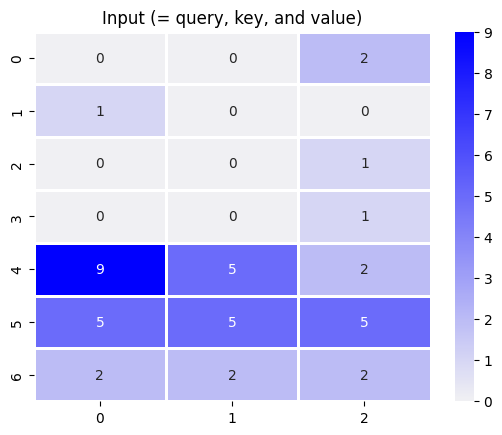

In [329]:
# input
Y = torch.cat((Q,K,V),axis=0)
print(Y)
sns.heatmap(Y.numpy(), annot=True, cmap=sns.light_palette('blue', as_cmap=True), linewidths=1).set_title('Input (= query, key, and value)');

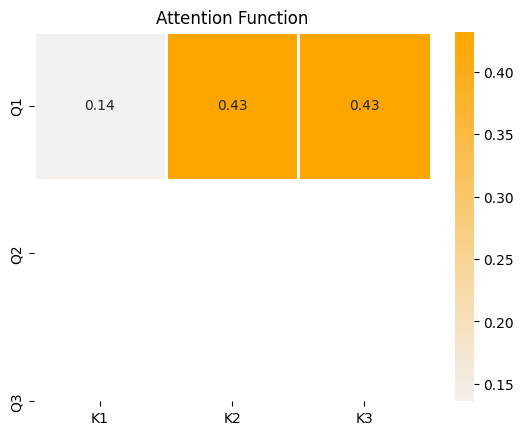

In [330]:
# attention matrix
# output
x_axis_labels = ['K1', 'K2', 'K3']
y_axis_labels = ['Q1', 'Q2', 'Q3']
sns.heatmap(p_attn.numpy(), annot=True,
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels,
            cmap=sns.light_palette("orange", as_cmap=True),
            linewidths=1).set_title('Attention Function'
            );

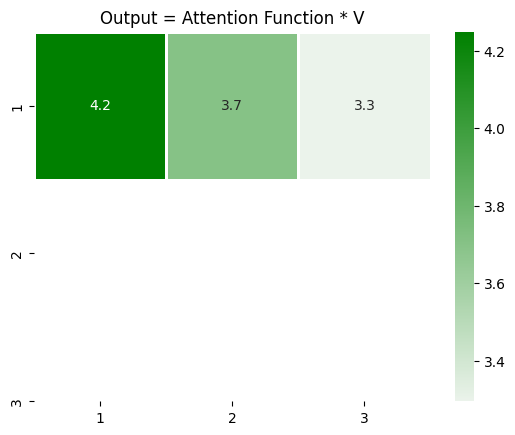

In [331]:
# output
x_axis_labels = ['1', '2', '3']
y_axis_labels = ['1', '2', '3']
sns.heatmap(out.numpy(), annot=True,
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels,
            cmap=sns.light_palette("green", as_cmap=True),
            linewidths=1).set_title('Output = Attention Function * V'
            );

Example calculation for the the first element in the output:<br>
The dot product of the first row of the attention matrix (p_attn[0,0]) with the first column of the value matrix (Y[0,:,0]).<br>
0.6 * 0.39 + 0.084 * -0.19 + 0.11 * -0.2 + 0.1 * 1.3 + 0.098 * 0.14 = 0.34 (0.33976)

In [182]:
p_attn[0,0].view(1,-1)

tensor([[1.]])

In [183]:
Q[0].view(-1,1)

tensor([[1.],
        [2.],
        [3.]])